# Imports

In [63]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
import pickle

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Flatten)
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import (Conv2D, MaxPooling2D)
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, RepeatVector, TimeDistributed, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

import gc
import ctypes

import warnings
warnings.filterwarnings('ignore')

# Dataset

In [2]:
STYLES_CSV_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"
IMAGES_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"

In [3]:
df = pd.read_csv(STYLES_CSV_PATH, on_bad_lines='skip')
print(f"Total Rows: {df.shape[0]}\nTotal Columns: {df.shape[1]}")

Total Rows: 44424
Total Columns: 10


In [5]:
# Adding Images paths to the df
df['image_path'] = df['id'].apply(lambda x: IMAGES_PATH + str(x) +'.jpg')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/kaggle/input/fashion-product-images-dataset/f...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/fashion-product-images-dataset/f...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/kaggle/input/fashion-product-images-dataset/f...


# Exploratory Data Analysis

## Handling Data Types

In [6]:
df.dropna()
# df = df.apply(lambda col: col.fillna('Unknown').astype(str) if col.name not in ['id'] else col)
df = df.astype({col: str for col in df.columns if col != 'id'})

## Missing Data

In [7]:
df.isna().sum()

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
image_path            0
dtype: int64

In [8]:
df = df[df['id'].isin([int(i.split('.')[0]) for i in os.listdir(IMAGES_PATH)])]

## Extracting Brands

In [9]:
def extract_brand(name):
    keywords = ['men', 'man', 'woman', 'women', 'boy', 'girl', 'kid', 'unisex']
    
    name_lower = name.lower()
    
    if "'" in name_lower:
        parts = name_lower.split("'", 1)
        before_quote = parts[0].strip()
        after_quote = parts[1].strip()

        words_before_quote = before_quote.split(' ')
        
        if words_before_quote[-1] in keywords:
            brand = ' '.join(words_before_quote[:-1])
        else:
            brand = before_quote
        
        brand = brand.strip()
    else:
        words = name_lower.split(' ')
        brand = name_lower
        for word in words:
            if word in keywords:
                brand = name_lower.split(word)[0].strip()
                break
        if brand == name_lower:
            brand = name_lower.split(' ')[0]
    
    # Capitalize the first letter of every word in the output
    return brand.title()

In [10]:
# df['brand'] = df['productDisplayName'].apply(extract_brand)

In [11]:
def refine_brands(df):
    brands = df['brand'].tolist()
    
    for i, brand in enumerate(brands):
        for j, other_brand in enumerate(brands):
            if i != j:
                if f' {other_brand} ' in f' {brand} ':
                    brands[i] = other_brand
                    break

    df['brand'] = brands

In [12]:
# refine_brands(df)

# Visualize

In [56]:
import seaborn as sns

def plot_token_size_frequency(df):
    VOCAB_SIZE = 10000
    OOV_TOKEN = '<OOV>'
    END_TOKEN = '<end>'

    tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
    tokenizer.fit_on_texts(df['productDisplayName'].values)
    
    if END_TOKEN not in tokenizer.word_index:
        tokenizer.word_index[END_TOKEN] = len(tokenizer.word_index) + 1

    end_token_id = tokenizer.word_index[END_TOKEN]

    sequences = tokenizer.texts_to_sequences(df['productDisplayName'].values)
    for seq in sequences:
        seq.append(end_token_id)

    seq_lengths = [len(seq) for seq in sequences]

    plt.figure(figsize=(10, 6))
    sns.histplot(seq_lengths, bins=30, kde=True)
    plt.title('Distribution of Token Sizes')
    plt.xlabel('Token Size')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

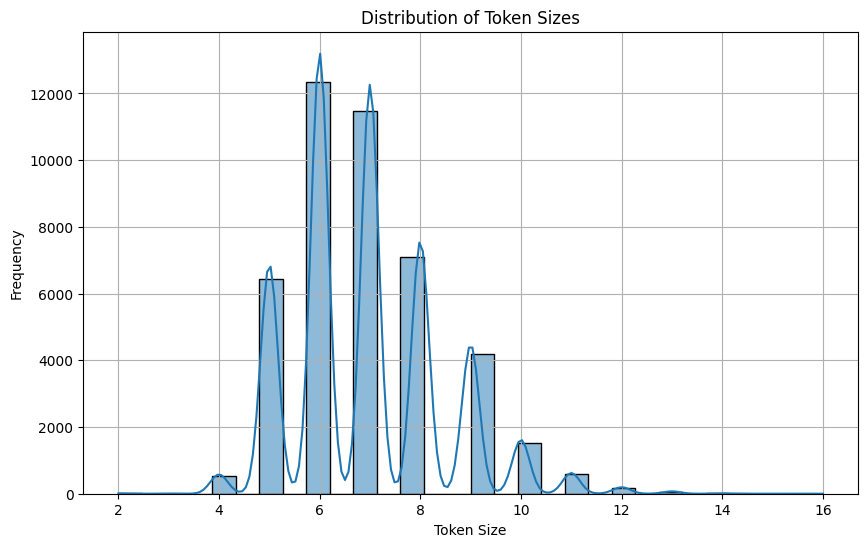

In [64]:
plot_token_size_frequency(df)

# Hyper Parameters

In [13]:
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180
IMAGE_CHANNELS = 3
EPOCHS = 40

In [14]:
MAX_SEQ_LENGTH = 30
VOCAB_SIZE = 5000    
LSTM_UNITS = 512
EMBEDDING_DIM = 256 
BATCH_SIZE = 32     
DEFAULT_MAX_SEQ_LENGTH = 30
DEFAULT_LSTM_UNITS = 512
UPPER_LIMIT_VOCAB_SIZE = 5000

In [15]:
def determine_lstm_units(descriptions):
    max_length = max(len(desc.split()) for desc in descriptions)
    lstm_units = min(2 * max_length, 1024)
    return lstm_units

# Pre-Processing

## Text

In [16]:
def preprocess_text(df):
    VOCAB_SIZE = 10000
    OOV_TOKEN = '<OOV>'
    END_TOKEN = '<end>'
    START_TOKEN = '<start>'

    tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
    
    tokenizer.fit_on_texts(df['productDisplayName'].values)
    
    if END_TOKEN not in tokenizer.word_index:
        tokenizer.word_index[END_TOKEN] = len(tokenizer.word_index) + 1

    end_token_id = tokenizer.word_index[END_TOKEN]

    sequences = tokenizer.texts_to_sequences(df['productDisplayName'].values)

    for seq in sequences:
        seq.append(end_token_id)

    MAX_SEQ_LENGTH = max(len(seq) for seq in sequences)

    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
    
    word_index = tokenizer.word_index
    VOCAB_SIZE = len(word_index) + 1

    return padded_sequences, word_index, tokenizer, MAX_SEQ_LENGTH, VOCAB_SIZE

In [17]:
padded_sequences, word_index, tokenizer, MAX_SEQ_LENGTH, VOCAB_SIZE = preprocess_text(df)

In [18]:
LSTM_UNITS = determine_lstm_units(df['productDisplayName'])

## Image

In [19]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

def preprocess_images(image_paths, image_size):
    if 'image_path' not in df.columns:
        raise ValueError("DataFrame must contain 'image_path' column.")

    image_data = []

    for img_path in tqdm(image_paths, desc="Processing images"):
        image = cv2.imread(img_path)
        if image is None:
            print(f"Error reading image at path: {img_path}")
            continue
        
        image = cv2.resize(image, (image_size[0], image_size[1]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_data.append(image)

    return np.array(image_data)


## One Hot

In [20]:
y = np.zeros((padded_sequences.shape[0], MAX_SEQ_LENGTH, VOCAB_SIZE), dtype='float32')
for i, seq in enumerate(padded_sequences):
    for j, word_id in enumerate(seq):
        if word_id != 0:
            y[i, j, word_id] = 1.0

# Model

## Architecture

In [21]:
def load_image_model(filepath):
    model = load_model(filepath, safe_mode=False)
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-1].output)
    return feature_extractor

In [22]:
def create_rnn_model(vocab_size, embedding_dim, max_seq_length, lstm_units):
    inputs = Input(shape=(None,))
    embedded_inputs = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    
    lstm = LSTM(lstm_units, return_sequences=True)(embedded_inputs)
    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(lstm)
    
    model = Model(inputs, outputs)
    return model

In [23]:
def create_combined_model(feature_extractor, rnn_model):
    image_input = feature_extractor.input
    image_features = feature_extractor.output
    
    image_features = Flatten()(image_features)
    image_features = Dense(EMBEDDING_DIM, activation='relu')(image_features)
    image_features = RepeatVector(MAX_SEQ_LENGTH)(image_features)
    
    text_input = Input(shape=(MAX_SEQ_LENGTH,))
    embedded_text_input = rnn_model.layers[1](text_input)
    
    combined_input = tf.keras.layers.concatenate([image_features, embedded_text_input])
    
    lstm = LSTM(LSTM_UNITS, return_sequences=True)(combined_input)
    output = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))(lstm)
    
    combined_model = Model([image_input, text_input], output)
    return combined_model

In [24]:
gc.collect()
libc = ctypes.CDLL("libc.so.6") # clearing cache 
libc.malloc_trim(0)

1

## Transfer Learning
Here is the model I've trained before for Fashion Image Classification

In [25]:
feature_extractor = load_image_model('/kaggle/input/classification-l20.02/keras/default/1/LastVersion-RESNET50-50-(180, 180, 3)-2024-08-02-13:16:29/model.keras')

## Model Compile

In [26]:
def perplexity(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])  # Flatten y_true if necessary
    cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    perplexity = tf.exp(tf.reduce_mean(cross_entropy))
    return perplexity

In [ ]:
from tensorflow.keras.optimizers import RMSprop

rnn_model = create_rnn_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQ_LENGTH, LSTM_UNITS)
combined_model = create_combined_model(feature_extractor, rnn_model)

combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

combined_model.summary()

# Data Split

In [29]:
X_train, X_val, X_train_seq, X_val_seq, y_train, y_val = train_test_split(
    df['image_path'], padded_sequences, y, test_size=0.2, random_state=42
)

In [30]:
X_train_img = preprocess_images(X_train, (IMAGE_HEIGHT, IMAGE_WIDTH))
X_val_img = preprocess_images(X_val, (IMAGE_HEIGHT, IMAGE_WIDTH))

Processing images: 100%|██████████| 4400/4400 [01:41<00:00, 43.26it/s]


In [31]:
gc.collect()
libc = ctypes.CDLL("libc.so.6") # clearing cache 
libc.malloc_trim(0)

1

# Training

In [32]:
history = combined_model.fit(
    [X_train_img, X_train_seq], y_train,
    validation_data=([X_val_img, X_val_seq], y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)

Epoch 1/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 90s 135ms/step - accuracy: 0.0654 - loss: 4.9620 - val_accuracy: 0.0625 - val_loss: 2.0503
Epoch 2/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 65s 118ms/step - accuracy: 0.0625 - loss: 1.9867 - val_accuracy: 0.0702 - val_loss: 1.7408
Epoch 3/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - accuracy: 0.0972 - loss: 1.6655 - val_accuracy: 0.1709 - val_loss: 1.4680
Epoch 4/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - accuracy: 0.1931 - loss: 1.4052 - val_accuracy: 0.2483 - val_loss: 1.2642
Epoch 5/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - accuracy: 0.2523 - loss: 1.2194 - val_accuracy: 0.2769 - val_loss: 1.1106
Epoch 6/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 66s 119ms/step - accuracy: 0.2791 - loss: 1.0661 - val_accuracy: 0.2908 - val_loss: 0.9816
Epoch 7/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 66s 119ms/step - accuracy: 0.2936 - loss: 0.9317 - val_accuracy: 0.3005 - val_loss: 0.8722
Epoch 8/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - accuracy: 0.3037 - loss: 0

In [39]:
history = history.history

# Saving

In [33]:
import datetime
now = datetime.datetime.now()
timestamp = now.strftime('%Y-%m-%d-%H:%M:%S')
timestamp

'2024-08-03-10:13:09'

In [34]:
DIR_PATH = f'{EPOCHS}-{timestamp}'
# DIR_PATH = '/kaggle/working'

if not os.path.exists(DIR_PATH):
    os.makedirs(DIR_PATH)

## Saving Model

In [35]:
combined_model.save_weights(os.path.join(DIR_PATH, 'model.weights.h5'))
combined_model.save(os.path.join(DIR_PATH, 'model.keras'))

## Saving Train History

In [37]:
import pickle

with open(os.path.join(DIR_PATH, 'model.history'), 'wb') as file_pi:
    pickle.dump(history, file_pi)

# Load

In [ ]:
# from keras.models import load_model

# model = load_model(os.path.join(DIR_PATH, 'model.keras'), safe_mode=False)

# with open(os.path.join(DIR_PATH, 'model.history'), "rb") as file_pi:
#     history = pickle.load(file_pi)

# Evaluation

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.savefig(os.path.join(DIR_PATH, 'accuracy_loss.png'))
plt.show()

In [44]:
!pip install nltk rouge-score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3707572a998c789921b1724b5761945b510e8ad004135fa32054f5c7927d62f5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [49]:
def clean_sequence(seq, reverse_word_index):
    """Convert a sequence of integers to a string of words, stopping at the <end> token."""
    words = [reverse_word_index.get(i, '') for i in seq if i != 0]
    if '<end>' in words:
        end_idx = words.index('<end>')
        words = words[:end_idx]
    return ' '.join(words)

def compute_scores(X_val_img, X_val_seq, combined_model, reverse_word_index, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS, MAX_SEQ_LENGTH, batch_size=32):
    bleu_scores = []
    rouge_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smoothing = SmoothingFunction().method1

    num_samples = len(X_val_img)
    num_batches = (num_samples + batch_size - 1) // batch_size

    for batch_index in range(num_batches):
        start = batch_index * batch_size
        end = min(start + batch_size, num_samples)

        batch_images = X_val_img[start:end].reshape((end - start, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
        batch_sequences = X_val_seq[start:end].reshape((end - start, MAX_SEQ_LENGTH))

        predictions = combined_model.predict([batch_images, batch_sequences], verbose=0)
        predicted_seqs = np.argmax(predictions, axis=-1)

        for i in range(end - start):
            actual_text = clean_sequence(X_val_seq[start + i], reverse_word_index)
            predicted_text = clean_sequence(predicted_seqs[i], reverse_word_index)
            
            bleu = sentence_bleu([actual_text.split()], predicted_text.split(), smoothing_function=smoothing)
            bleu_scores.append(bleu)
            
            rouge = scorer.score(actual_text, predicted_text)
            rouge_scores.append(rouge)
    
    average_bleu = np.mean(bleu_scores)
    average_rouge1 = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
    average_rouge2 = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
    average_rougeL = np.mean([score['rougeL'].fmeasure for score in rouge_scores])

    return average_bleu, average_rouge1, average_rouge2, average_rougeL

In [50]:
average_bleu, average_rouge1, average_rouge2, average_rougeL = compute_scores(X_val_img, X_val_seq, combined_model, reverse_word_index, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS, MAX_SEQ_LENGTH)

In [51]:
print(f'Average BLEU Score: {average_bleu:.4f}')
print(f'Average ROUGE-1 F1 Score: {average_rouge1:.4f}')
print(f'Average ROUGE-2 F1 Score: {average_rouge2:.4f}')
print(f'Average ROUGE-L F1 Score: {average_rougeL:.4f}')

Average BLEU Score: 0.8994
Average ROUGE-1 F1 Score: 0.9532
Average ROUGE-2 F1 Score: 0.9394
Average ROUGE-L F1 Score: 0.9532


# Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


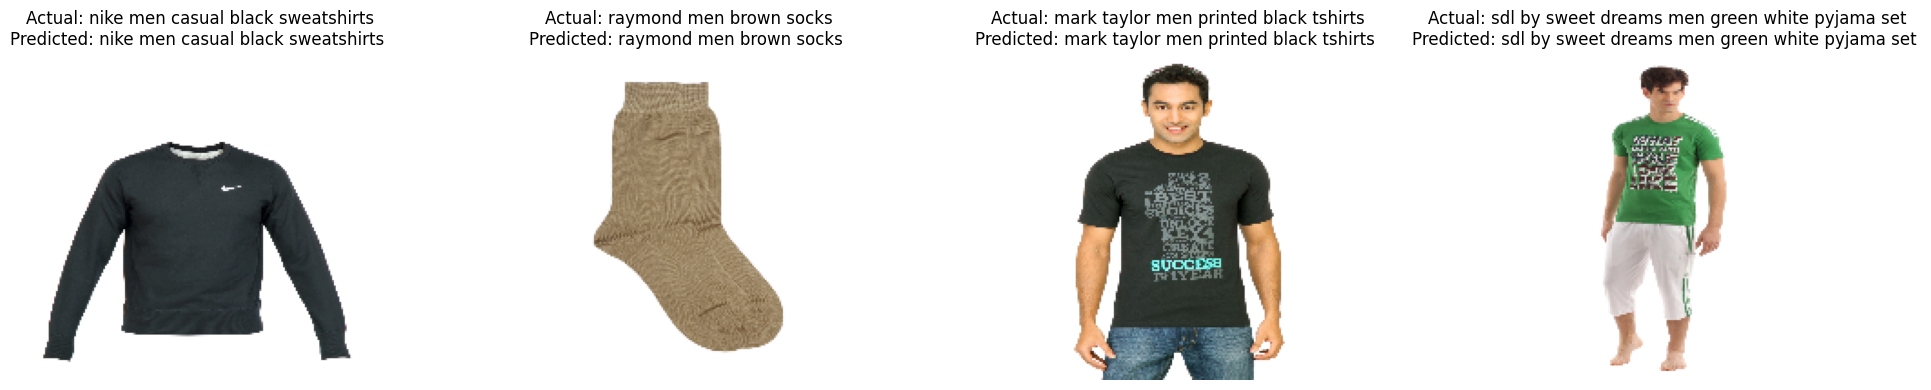

In [42]:
sample_indices = np.random.choice(len(X_val_img), size=4, replace=False)
reverse_word_index = {v: k for k, v in word_index.items()}

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for ax, idx in zip(axes, sample_indices):
    img = X_val_img[idx]
    actual_seq = X_val_seq[idx]
    actual_text = ' '.join([reverse_word_index.get(i, '') for i in actual_seq if i != 0 and reverse_word_index.get(i, '') != '<end>'])

    prediction = combined_model.predict([img.reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), '<start>'])
    predicted_seq = np.argmax(prediction, axis=-1).flatten()
    predicted_text = ' '.join([reverse_word_index.get(i, '') for i in predicted_seq if i != 0])
    if '<end>' in predicted_text:
        found_id = predicted_text.find('<end>')
        predicted_text = predicted_text[:found_id]
    
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Actual: {actual_text}\nPredicted: {predicted_text}")

plt.tight_layout()
now = datetime.datetime.now()
timestamp = now.strftime('%Y-%m-%d-%H:%M:%S')
plt.savefig(f'sample_predictions-{timestamp}.png')
plt.show()